In [1]:
from rustworkx.visualization import mpl_draw as draw
from qiskit.visualization import plot_distribution
from qiskit.primitives import Estimator, Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import rustworkx as rx
import networkx as nx
import pandas as pd
import numpy as np

# à ajuster : prendre directement le fichier .npz pour la matrice d'adjacence
# Entrées : fichier csv contenant la matrice d'adjacence avec poids créé avec build_graph.py output mat_adj.csv 
# On pourrait ajouter un paramètre pour donner un nom à la matrice d'adjacence qu'on output 
df = pd.read_csv("mat_adj.csv")
# df.pop("Unnamed: 0")
mat_adj = np.array(df)

C:\Users\harsh\AppData\Local\Temp\ipykernel_15280\277318703.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


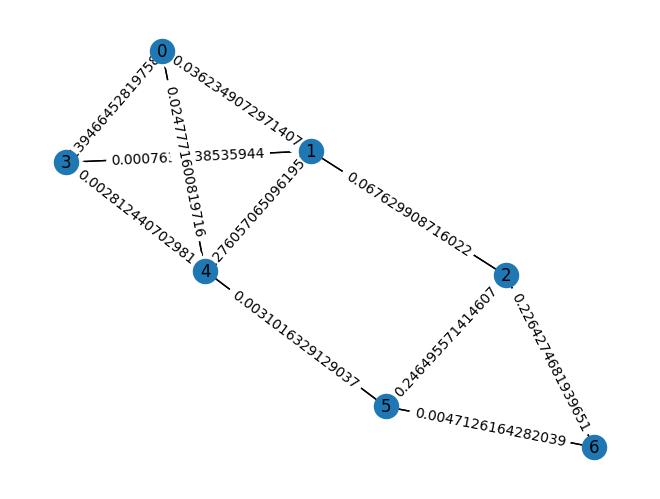

In [2]:
# With the adjacency matrix, we can build a graph : 
graph_cross = rx.PyGraph()
num_nodes_cross_graph = len(df)
nodes_list = graph_cross.add_nodes_from((range(num_nodes_cross_graph)))
# Add edges : 
edges = []
for i in range(num_nodes_cross_graph):
    for j in range(num_nodes_cross_graph):
        if mat_adj[i, j] != 0:
            edges.append((i, j, mat_adj[i, j]))
            
# print(edges)
graph_cross.add_edges_from(edges)

draw(graph_cross, with_labels=True, edge_labels=str) # type: ignore
plt.show()


### Ceci correspond bien aux noeuds correspondant aux deux premières colonnes du fibercup, du noeuds 0 à 6 comptabilisant 7 noeuds au total: 

![Fibercup](fibercup.png)

#### Matrice d'adjacence pondérée pour les 7 premiers noeuds du Fibercup: 

$\begin{bmatrix}
0.        & 0.03623491 & 0.           & 0.13946645  & 0.02477716  & 0.          & 0.       \\
0.03623491& 0.         &  0.06762991  & 0.00076388  & 0.27605707  & 0.          & 0.        \\
0.        & 0.06762991 & 0.           & 0.          & 0.          & 0.24649557  & 0.22642747\\
0.13946645& 0.00076388 & 0.           &0.           & 0.00281244  &0.           & 0.        \\
0.02477716& 0.27605707 & 0.           & 0.00281244  & 0.          & 0.00310163  & 0.        \\
0.        &0.          & 0.24649557   & 0.          & 0.00310163  & 0.          & 0.00471262\\
0.        &0.          &0.22642747    & 0.          & 0.          & 0.00471262  & 0.        \\
\end{bmatrix}
$

In [3]:

mat_triang_sup = np.triu(mat_adj)
mat_triang_sup = np.array(mat_triang_sup)


# Déterminer les connexions possibles entre chaque noeud voisin: 
all_possible_connexions = []

for start in range(num_nodes_cross_graph): 
    start_node_adj_mat = mat_adj[start]
    possible_starts = []
    for node,value in enumerate(start_node_adj_mat):
        if value>0:
            possible_starts.append(node)
    all_possible_connexions.extend([possible_starts])
    print(f'Possible connexions from node {start} to node(s) : {possible_starts}')
print(f'Toutes connexions possibles (doublées) : {all_possible_connexions} \n')


# Déterminer le nom des edges: 
list_of_nodes_for_naming_edges = []
destination= []
number_of_edges = 0

for start in range(num_nodes_cross_graph-1): 
    start_node_adj_mat = mat_triang_sup[start]
    end_edge = []
    for node,value in enumerate(start_node_adj_mat):
        if value>0:
            end_edge.append(node)
            number_of_edges+=1 
            destination.append(node)
    list_of_nodes_for_naming_edges.extend([end_edge])
    print(f'Edges from node {start} to node(s) : {end_edge}')
print(f'Toutes connexions sans doublement: {list_of_nodes_for_naming_edges}')

q_indices = []
depart = []
index = 0 
num_nodes_minus_1 = num_nodes_cross_graph - 1
for i in range(num_nodes_minus_1):
    for j in list_of_nodes_for_naming_edges[i]:
        depart.append(i)
        q_indices.append(index)
        index +=1
        
print(f'Indice :{q_indices}')
print(f'Départ :{depart}')
print(f'Destin :{destination}')

weights = []
for a in range(number_of_edges):
    for i in depart:
        for j in destination: 
            weight_qubit = mat_adj[depart,destination]
weights.append(weight_qubit)
weights[0][0]



Possible connexions from node 0 to node(s) : [1, 3, 4]
Possible connexions from node 1 to node(s) : [0, 2, 3, 4]
Possible connexions from node 2 to node(s) : [1, 5, 6]
Possible connexions from node 3 to node(s) : [0, 1, 4]
Possible connexions from node 4 to node(s) : [0, 1, 3, 5]
Possible connexions from node 5 to node(s) : [2, 4, 6]
Possible connexions from node 6 to node(s) : [2, 5]
Toutes connexions possibles (doublées) : [[1, 3, 4], [0, 2, 3, 4], [1, 5, 6], [0, 1, 4], [0, 1, 3, 5], [2, 4, 6], [2, 5]] 

Edges from node 0 to node(s) : [1, 3, 4]
Edges from node 1 to node(s) : [2, 3, 4]
Edges from node 2 to node(s) : [5, 6]
Edges from node 3 to node(s) : [4]
Edges from node 4 to node(s) : [5]
Edges from node 5 to node(s) : [6]
Toutes connexions sans doublement: [[1, 3, 4], [2, 3, 4], [5, 6], [4], [5], [6]]
Indice :[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Départ :[0, 0, 0, 1, 1, 1, 2, 2, 3, 4, 5]
Destin :[1, 3, 4, 2, 3, 4, 5, 6, 4, 5, 6]


0.0362349072971407

Voici l'allure du nouvel Hamiltonien : 

dernier terme : produit de Z connecté à chaque noeud intermédiaire - I 

In [4]:

all_weights_sum  = sum(np.tril(mat_adj).flatten())

pauli_weight_first_term = []
# Terme "IIIIII...I": 
pauli_weight_first_term.append(("I" * number_of_edges, all_weights_sum / 2))

# Z à la bonne position: 
for i in range(number_of_edges):
    str = ("I" * (number_of_edges - i - 1) + "Z" + "I" * i, -weights[0][i] / 2)
    pauli_weight_first_term.append(str)

h_c = SparsePauliOp.from_list(pauli_weight_first_term)
print(f'Coût obligatoire =\n {h_c}')
all_weights_sum

Coût obligatoire =
 SparsePauliOp(['IIIIIIIIIII', 'IIIIIIIIIIZ', 'IIIIIIIIIZI', 'IIIIIIIIZII', 'IIIIIIIZIII', 'IIIIIIZIIII', 'IIIIIZIIIII', 'IIIIZIIIIII', 'IIIZIIIIIII', 'IIZIIIIIIII', 'IZIIIIIIIII', 'ZIIIIIIIIII'],
              coeffs=[ 5.14239554e-01+0.j, -1.81174536e-02+0.j, -6.97332264e-02+0.j,
 -1.23885800e-02+0.j, -3.38149544e-02+0.j, -3.81941927e-04+0.j,
 -1.38028533e-01+0.j, -1.23247786e-01+0.j, -1.13213734e-01+0.j,
 -1.40622035e-03+0.j, -1.55081646e-03+0.j, -2.35630821e-03+0.j])


1.0284791075173432

In [5]:
# Contrainte pour le départ : 
noeud_de_depart  = 0 

qubit_depart =[] 
for node, value in enumerate(depart):
    if value == noeud_de_depart:
        qubit_depart.append(q_indices[node])
for node, value in enumerate(destination):
    if value == noeud_de_depart:
        qubit_depart.append(q_indices[node])
print(f'Qubit à sommer sur les x_i de départ: q({qubit_depart}) - I ')

Qubit à sommer sur les x_i de départ: q([0, 1, 2]) - I 


In [6]:
# Contruire la chaîne de Pauli pour la contrainte de départ : 
h_s = SparsePauliOp.from_list([("IIIIIIIIIII",  0.5),
                               ("IIIIIIIIIIZ", -0.5),
                               ("IIIIIIIIIZI", -0.5),
                               ("IIIIIIIIZII", -0.5)])

In [7]:
# Contrainte sur la fin: 
noeud_de_fin  = 5 

qubit_end =[] 
for node, value in enumerate(destination):
    if value == noeud_de_fin:
        qubit_end.append(q_indices[node])
for node, value in enumerate(depart):
    if value == noeud_de_fin:
        qubit_end.append(q_indices[node])
print(f'Qubit à sommer sur les x_i de fin: q({qubit_end}) - I ')


Qubit à sommer sur les x_i de fin: q([6, 9, 10]) - I 


In [8]:
# Contruire la chaîne de Pauli pour la contrainte de fin : 
h_f = SparsePauliOp.from_list([("IIIIIIIIIII",  0.5),
                               ("IIIIZIIIIII", -0.5),
                               ("IZIIIIIIIII", -0.5),
                               ("ZIIIIIIIIII", -0.5)])

In [9]:
# Contrainte intermédiaire: 
noeuds_int = []
for node, value in enumerate(depart):
    if (value != noeud_de_depart) and (value != noeud_de_fin):
        if value not in noeuds_int:
            noeuds_int.append(depart[node])
for node, value in enumerate(destination):
    if (value != noeud_de_depart) and (value != noeud_de_fin):
        if value not in noeuds_int:
            noeuds_int.append(destination[node])
                                
print(f'Liste de noeuds intermédiaires: {noeuds_int} \n')

liste_qubits_int = [ [] for _ in range(len(noeuds_int)) ]
for i, node in enumerate(noeuds_int):
    for node, value in enumerate(destination):
        if value == noeuds_int[i]:
            liste_qubits_int[i].append(q_indices[node])
    for node, value in enumerate(depart):
        if value == noeuds_int[i]:
            liste_qubits_int[i].append(q_indices[node])
            
for i in range(len(liste_qubits_int)):
    a = liste_qubits_int[i]
    print(f'Qubit à multiplier sur les x_i intermédiaires: q({a}) ')


Liste de noeuds intermédiaires: [1, 2, 3, 4, 6] 

Qubit à multiplier sur les x_i intermédiaires: q([0, 3, 4, 5]) 
Qubit à multiplier sur les x_i intermédiaires: q([3, 6, 7]) 
Qubit à multiplier sur les x_i intermédiaires: q([1, 4, 8]) 
Qubit à multiplier sur les x_i intermédiaires: q([2, 5, 8, 9]) 
Qubit à multiplier sur les x_i intermédiaires: q([7, 10]) 


In [10]:
# Contruire la chaîne de Pauli pour la contrainte intermédiaire : 
h_1 = SparsePauliOp.from_list([("IIIIIIIIIII", -1.0),
                               ("IIIIIZZZIIZ",  1.0)])

h_2 = SparsePauliOp.from_list([("IIIIIIIIIII", -1.0),
                               ("IIIZZIIZIII",  1.0)])

h_3 = SparsePauliOp.from_list([("IIIIIIIIIII", -1.0),
                               ("IIZIIIZIIZI",  1.0)])

h_4 = SparsePauliOp.from_list([("IIIIIIIIIII", -1.0),
                               ("IZZIIZIIZII",  1.0)])

h_5 = SparsePauliOp.from_list([("IIIIIIIIIII", -1.0),
                               ("ZIIZIIIIIII",  1.0)])

#### Autre version : 
problème avec les multiplications 

In [11]:
# Contruire la chaîne de Pauli pour la contrainte intermédiaire : 
h_11 = SparsePauliOp.from_list([("IIIIIIIIIII",  2.0),
                                ("IIIIIIIIIIZ", -0.5),
                                ("IIIIIIIZIII", -0.5),
                                ("IIIIIIZIIII", -0.5),
                                ("IIIIIZIIIII", -0.5)])

h_12 = SparsePauliOp.from_list([("IIIIIIIIIIZ", -0.5),
                                ("IIIIIIIZIII", -0.5),
                                ("IIIIIIZIIII", -0.5),
                                ("IIIIIZIIIII", -0.5)])


h_21 = SparsePauliOp.from_list([("IIIIIIIIIII",  1.5),
                                ("IIIIIIIZIII", -0.5),
                                ("IIIIZIIIIII", -0.5),
                                ("IIIZIIIIIII", -0.5)])

h_22 = SparsePauliOp.from_list([("IIIIIIIIIII", -0.5),
                                ("IIIIIIIZIII", -0.5),
                                ("IIIIZIIIIII", -0.5),
                                ("IIIZIIIIIII", -0.5)])


h_31 = SparsePauliOp.from_list([("IIIIIIIIIII",   1.5),
                                ("IIIIIIIIIZI",  -0.5),
                                ("IIIIIIZIIII",  -0.5),
                                ("IIZIIIIIIII",  -0.5)])

h_32 = SparsePauliOp.from_list([("IIIIIIIIIII",  -0.5),
                                ("IIIIIIIIIZI",  -0.5),
                                ("IIIIIIZIIII",  -0.5),
                                ("IIZIIIIIIII",  -0.5)])


h_41 = SparsePauliOp.from_list([("IIIIIIIIIII",  2.0),
                                ("IIIIIIIIZII", -0.5),
                                ("IIIIIZIIIII", -0.5),
                                ("IIZIIIIIIII", -0.5),
                                ("IZIIIIIIIII", -0.5)])

h_42 = SparsePauliOp.from_list([("IIIIIIIIZII", -0.5),
                                ("IIIIIZIIIII", -0.5),
                                ("IIZIIIIIIII", -0.5),
                                ("IZIIIIIIIII", -0.5)])


h_51 = SparsePauliOp.from_list([("IIIIIIIIIII",  1.0),
                                ("IIIZIIIIIII", -0.5),
                                ("ZIIIIIIIIII", -0.5)])

h_52 = SparsePauliOp.from_list([("IIIIIIIIIII", -1.0),
                                ("IIIZIIIIIII", -0.5),
                                ("ZIIIIIIIIII", -0.5)])

# h_int = (h_11)**2 * (h_12)**2  + (h_21)**2 * (h_22)**2  + (h_31)**2 * (h_32)**2 + (h_41)**2 * (h_42)**2  + (h_51)**2 * (h_52)**2





In [12]:
# Alpha shouldn't be too big to keep the energy spectrum of the hamiltonian usable with QAOA.
alpha = 0.8
# QUBO representation of Hamiltonian (cost function).
h = - h_c + alpha * ((h_s**2) + (h_f**2) + (h_1**2)  + (h_2**2) + (h_3**2) + (h_4**2) + (h_5**2))


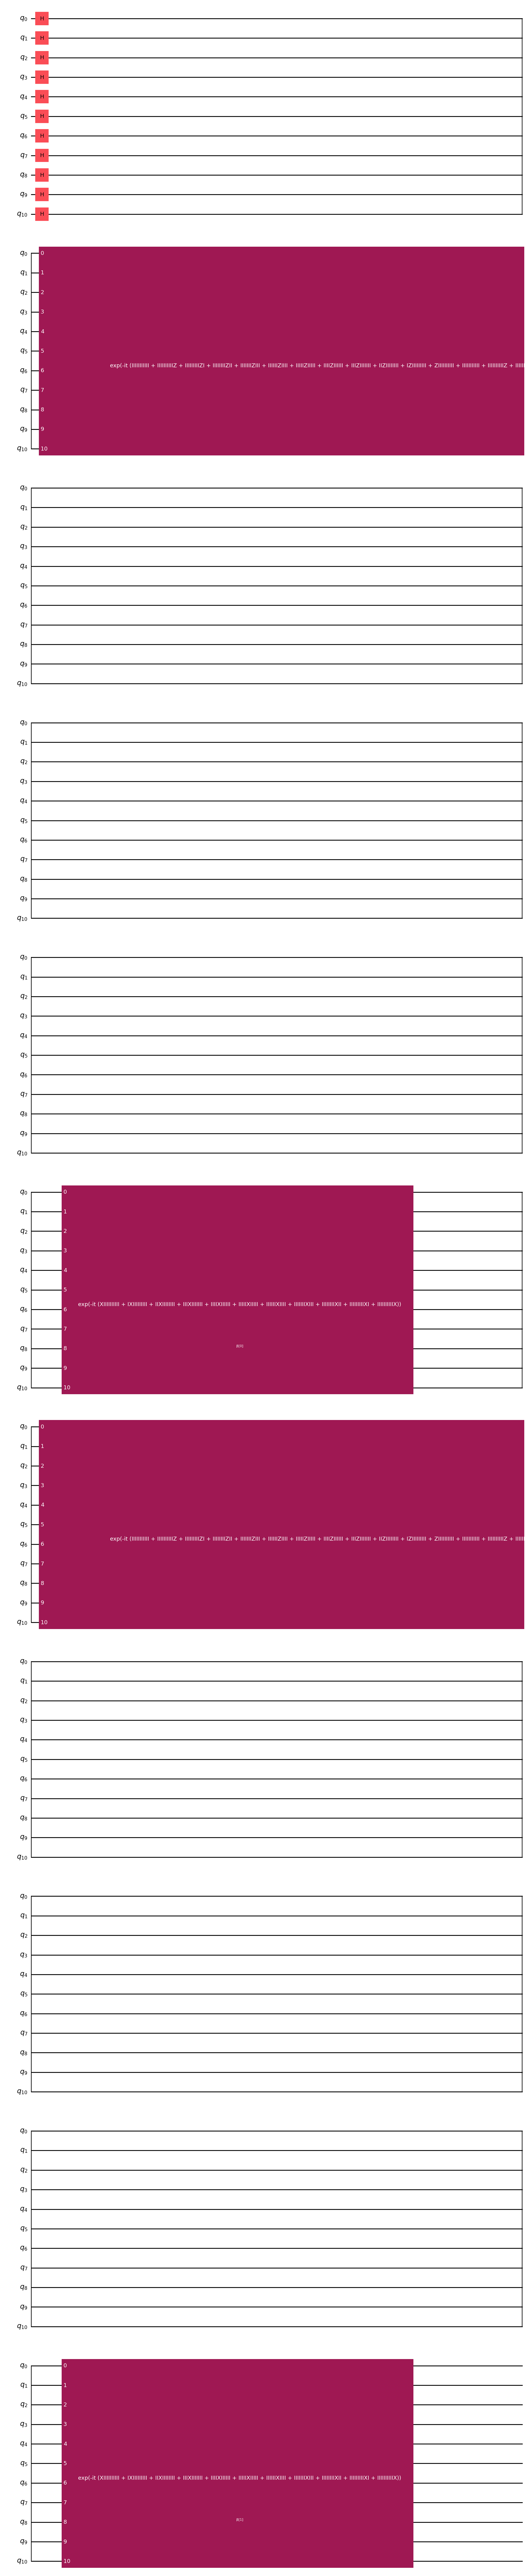

In [13]:
# Create QAOA circuit.
ansatz = QAOAAnsatz(h, reps=2)
ansatz.decompose(reps=1).draw(output="mpl", style="iqp")

In [14]:
# Run on local estimator and sampler. Fix seeds for results reproducibility.
estimator = Estimator(options={"shots": 1000000, "seed" : 42})
sampler = Sampler(options={"shots": 1000000, "seed" :42})

In [15]:
# Cost function for the minimizer.
# Returns the expectation value of circuit with Hamiltonian as an observable.
def cost_func(params, estimator, ansatz, hamiltonian):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [16]:
# Generate starting point. Fixed to zeros for results reproducibility.
# x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
x0 = np.zeros(ansatz.num_parameters)

res = minimize(cost_func, x0, args=(estimator, ansatz, h), method="COBYLA")
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 3.760003146683984
       x: [ 8.244e-01  2.621e-01  7.014e-02 -3.259e-01]
    nfev: 115
   maxcv: 0.0


In [17]:
cost_func([ 8.250e-01  ,2.622e-01  ,5.591e-02 ,-2.605e-01],estimator, ansatz, h)

4.036627238896233

In [18]:
# Get probability distribution associated with optimized parameters.
circ = ansatz.copy()
circ.measure_all()
dist = sampler.run(circ, res.x).result().quasi_dists[0]



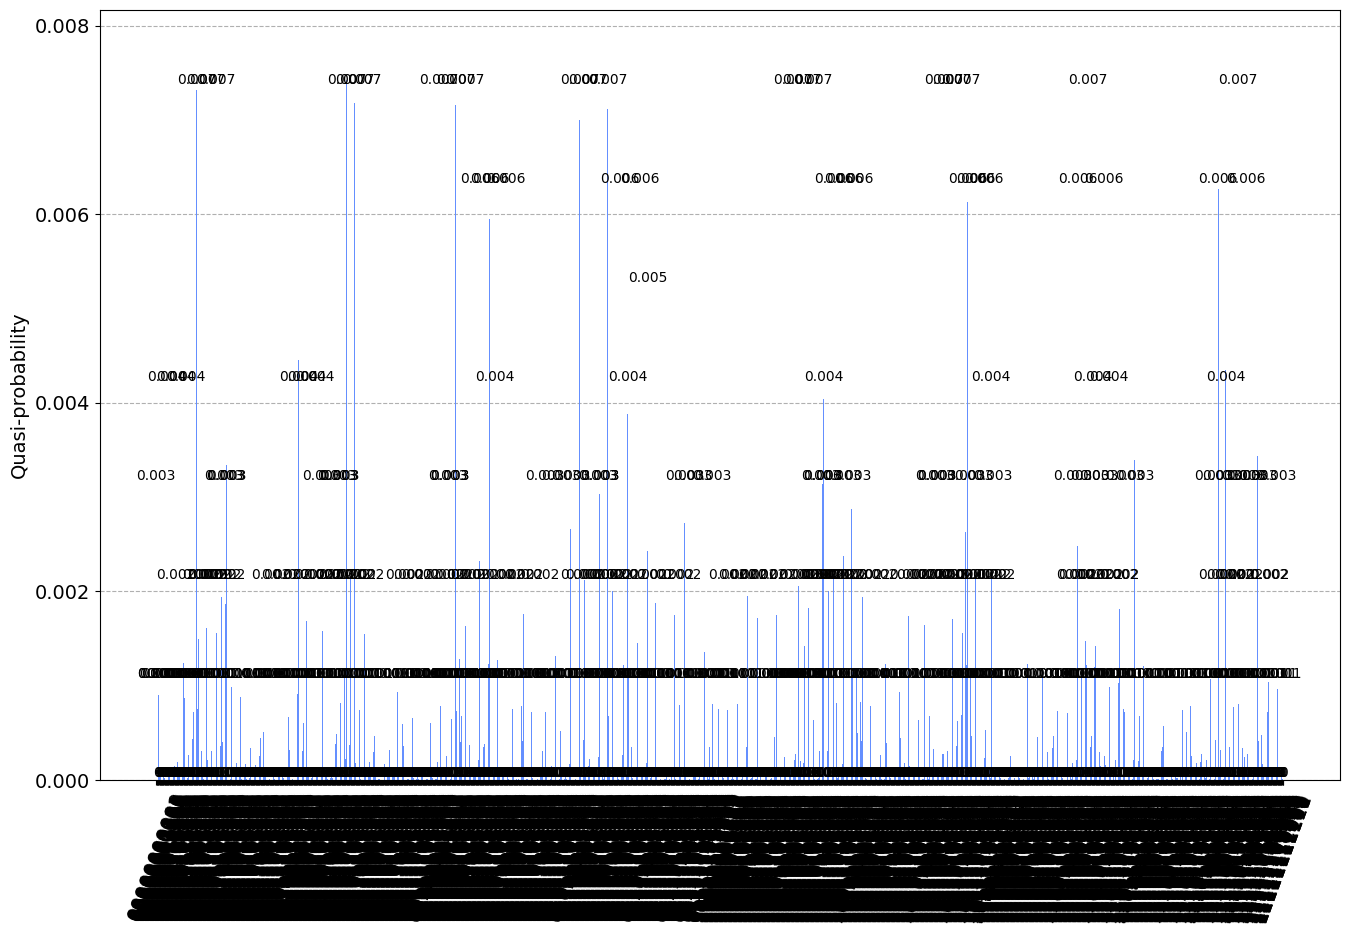

In [19]:

plot_distribution(dist.binary_probabilities(), figsize=(16, 10))

In [20]:
print(max(dist.binary_probabilities(), key=dist.binary_probabilities().get)) # type: ignore
print(sorted(dist.binary_probabilities(), key=dist.binary_probabilities().get)) # type: ignore

00101011100
['00011001111', '00011011000', '00011011100', '00011101010', '00011101011', '00110000000', '00110100000', '00110110011', '00111001000', '00111001001', '01001110100', '01010000110', '01010010011', '01010110101', '01011011010', '01011101100', '01011101110', '01011111001', '01110100000', '01111011010', '01111011100', '01111011110', '01111101010', '10000011100', '10000101010', '10000101110', '10000111000', '10001001111', '10001010000', '10001010100', '10100001000', '10100101100', '10101100000', '10101100100', '10101110011', '10110010110', '11000001110', '11000011001', '11000101101', '11000101110', '11001100111', '11001101101', '11001111000', '11100111110', '11101001000', '00001100110', '00011101110', '00011111101', '00111101100', '00111111011', '00111111110', '01010110110', '01011001011', '01011011001', '01011011100', '01011101010', '01011101111', '01110000000', '01110000110', '01111001001', '01111001101', '01111111111', '10001110001', '10010100110', '10100001001', '10100111111

In [21]:
# # Plot graph

# G = nx.Graph()

# G.add_edge(0, 1, weight=int(mat_adj[0,1]))
# G.add_edge(0, 3, weight=int(mat_adj[0,3]))
# G.add_edge(0, 4, weight=int(mat_adj[0,4]))
# G.add_edge(1, 2, weight=int(mat_adj[1,2]))
# G.add_edge(1, 3, weight=int(mat_adj[1,3]))
# G.add_edge(1, 4, weight=int(mat_adj[1,4]))
# G.add_edge(2, 5, weight=int(mat_adj[2,5]))
# G.add_edge(2, 6, weight=int(mat_adj[2,6]))
# G.add_edge(3, 4, weight=int(mat_adj[3,4]))
# G.add_edge(4, 5, weight=int(mat_adj[4,5]))
# G.add_edge(5, 6, weight=int(mat_adj[5,6]))

# pos = nx.spring_layout(G)
# edge_labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_nodes(G, pos, node_size=400, node_color="#797EF6")
# nx.draw_networkx_edges(G, pos, width=2, edge_color="#797EF6")
# nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", font_color="w")
# nx.draw_networkx_edge_labels(G, pos,edge_labels)



# ax = plt.gca()
# ax.margins(0.08)
# plt.axis("off")
# plt.tight_layout()
# plt.show()
# print(max(dist.binary_probabilities(), key=dist.binary_probabilities().get))
# print(sorted(dist.binary_probabilities(), key=dist.binary_probabilities().get))

In [22]:
# # Display graph
# bin_str = list(map(int, max(dist.binary_probabilities(), key=dist.binary_probabilities().get))) # type: ignore
# bin_str.reverse()
# print(bin_str)


# pos = nx.spring_layout(G, seed=7)
# edge_labels = nx.get_edge_attributes(G, "weight")

# e_in  = [(u, v) for i, (u, v, d) in enumerate(G.edges(data=True)) if bin_str[i]]
# e_out  = [(u, v) for i, (u, v, d) in enumerate(G.edges(data=True)) if not bin_str[i]]

# print(e_in)

# color_map = np.array(["#D3D3D3"] * G.number_of_nodes())
# print(list(sum(e_in, ())))
# color_map[list(sum(e_in, ()))] = "#EE6B6E"

# nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=400)
# nx.draw_networkx_edges(G, pos, edgelist=e_in, width=2, alpha=1, edge_color="#EE6B6E", style="dashed")
# nx.draw_networkx_edges(G, pos, edgelist=e_out, width=2, edge_color="#D3D3D3")
# nx.draw_networkx_edge_labels(G, pos, edge_labels)
# nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", font_color="w")

# ax = plt.gca()
# ax.margins(0.08)
# plt.axis("off")
# plt.tight_layout()
# plt.show()